# Data preparation


## File list
The directory structure of the actual annotations is quite odd.
Below some path magics to extract the filenames for both: images and xml annotations.

In [1]:
from pathlib import Path, PosixPath

In [2]:
import itertools

In [3]:
# set the path to where the annotations are

In [4]:
annotations = '/home/epinux/annotate2/'

In [5]:
jpeg_files = [str(i) for i in itertools.chain.from_iterable(
            [list(i.glob('*.jpg')) for i in itertools.chain.from_iterable(
                [sorted(i.glob('*')) for i in sorted(Path(annotations).glob('*'))])])]

In [6]:
len(jpeg_files)

2635

In [7]:
xml_files = [str(i) for i in itertools.chain.from_iterable(
            [list(i.glob('*.xml')) for i in itertools.chain.from_iterable(
                [sorted(i.glob('*')) for i in sorted(Path(annotations).glob('*'))])])]

## Subsampling

Reduce the `xml` annotation files with a reduce factor $R_f$
Starting value:

$$
R_f=0.125 \quad \text{which will reduce the amount of files to 12.5% of the total}
$$

In [8]:
import numpy as np
reduce_factor = 0.125
np.random.seed(0)
msk = np.random.rand(len(xml_files), ) < reduce_factor
sample = list(np.array(xml_files)[msk])

In [9]:
len(sample)

339

In [10]:
sample[:5]

['/home/epinux/annotate2/cat1/cat1_0/201503.20150602.113901432.55596.orig.xml',
 '/home/epinux/annotate2/cat1/cat1_0/201503.20150602.113901762.55598.orig.xml',
 '/home/epinux/annotate2/cat1/cat1_0/201403.20140722.024040614.218668.orig.xml',
 '/home/epinux/annotate2/cat1/cat1_0/201303.20130711.191010294.1022035.orig.xml',
 '/home/epinux/annotate2/cat1/cat1_0/201303.20130710.193557273.504810.orig.xml']

## Annotation Parsing

Parsing each `xml` file and store the resutls as `pandas.Dataframe`


In [11]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

In [12]:
def xml_to_csv(xml_files):
    xml_list = []
    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [13]:
records = xml_to_csv(sample)

Get an idea of which labels are in all the annotations

In [14]:
list(records['class'].unique())

['Substrate E',
 'Small shell hash',
 'Scallop',
 'Substrate A',
 'sand dollar',
 'Cerianthus sp',
 'difficult',
 'Substrate B',
 'Large shell hash',
 'Substrate F',
 'Hermit crab',
 'Asterias sp',
 'Skate',
 'Whelk',
 'Hydractinia echinata',
 'Barnacles',
 'Shrimp',
 'Coral',
 'Halichondria',
 'white anemone',
 'waved whelk',
 'Botrylloides sp',
 'Too Difficult',
 'Hake',
 'Cancer sp',
 'Moon Snail',
 'Nudibranch',
 'Clam',
 'Bivalve',
 'Henricia sanguinolenta',
 'Leucosolenia',
 'Substrate D',
 'Ocean Pout',
 'Gadid',
 'Substrate C',
 'Threeline Mud Snail',
 'Mottled Sea Star']

In [15]:
records.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,201503.20150602.113901432.55596.orig.jpg,1360,1024,Substrate E,72,44,126,91
1,201503.20150602.113901432.55596.orig.jpg,1360,1024,Small shell hash,149,51,192,94
2,201503.20150602.113901762.55598.orig.jpg,1360,1024,Substrate E,68,52,120,96
3,201503.20150602.113901762.55598.orig.jpg,1360,1024,Small shell hash,146,51,196,104
4,201503.20150602.113901762.55598.orig.jpg,1360,1024,Scallop,178,98,283,217


In [16]:
records.describe()

,width,height,xmin,ymin,xmax,ymax
count,8451.0,8451.0,8451.000000,8451.000000,8451.000000,8451.000000
mean,1360.0,1024.0,634.302213,463.971719,678.500887,508.176310
std,0.0,0.0,394.956244,300.118176,396.292298,301.462282
min,1360.0,1024.0,1.000000,1.000000,25.000000,21.000000
25%,1360.0,1024.0,280.000000,193.000000,326.000000,240.000000
50%,1360.0,1024.0,625.000000,454.000000,671.000000,501.000000
75%,1360.0,1024.0,977.000000,727.000000,1022.000000,772.000000
max,1360.0,1024.0,1341.000000,1010.000000,1360.000000,1024.000000


In [17]:
%matplotlib inline

Simple statistic description of the sample

/usr/local/lib/python3.7/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


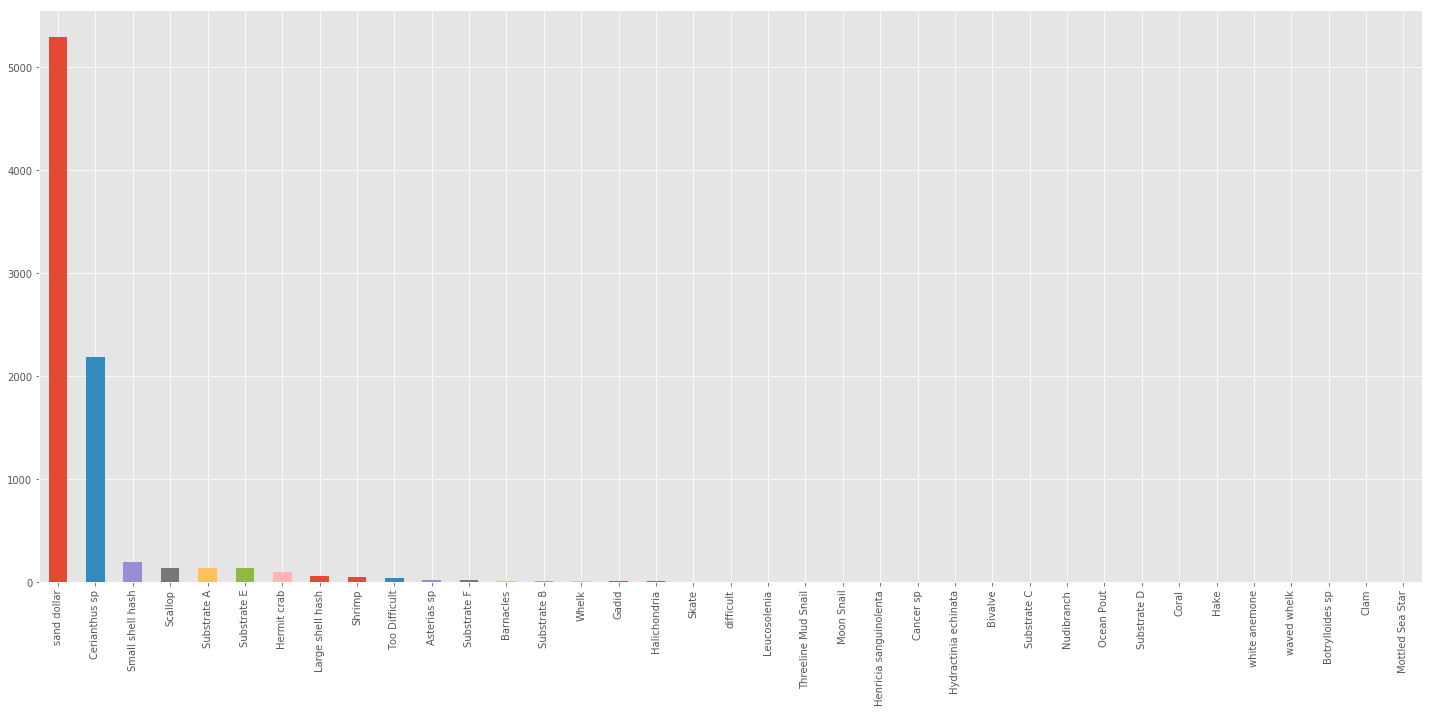

In [18]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(20,10))
records['class'].value_counts().plot(kind='bar')
plt.tight_layout()
plt.show()
plt.close()

In [19]:
# import holoviews as hv
# hv.extension('bokeh')
# bars = hv.Bars(records['class'].value_counts(), hv.Dimension('index'), 'class').options(width=900, height=500, xrotation= 38)
# bars

Extract only the `sand dollars` annotations

In [20]:
records = records[records['class']=="sand dollar"]

## Train & Test

Split the sampling in training ($70\%$) and testing ($30\%$) dataset

In [21]:
import numpy as np
msk = np.random.rand(len(records)) < 0.7
train = records[msk]
test = records[~msk]

In [22]:
train.shape

(3780, 8)

In [23]:
test.shape

(1514, 8)

In [24]:
test.to_csv('test.csv', index=False)
train.to_csv('train.csv', index=False)

## TensorFlow records


In [25]:
# for converting the csv/pandas dataframe into TFRecord format
# https://stackoverflow.com/questions/41402332/tensorflow-create-a-tfrecords-file-from-csv

import pandas as pd
import tensorflow as tf
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# The function takes in the all of the features of a single annotation instance as a list, and then also the label as its own variable
# it creates a TFRecord (see below cell for how the format looks, similar to XML)

def create_tf_example(features, label):

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[features[0].encode('utf-8')])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[1])])),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[2])])),
        'class':tf.train.Feature(bytes_list=tf.train.BytesList(value=[label.encode('utf-8')])),
        'xmin':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[3])])),
        'ymin':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[4])])),
        'xmax':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[5])])),
        'ymax':tf.train.Feature(int64_list=tf.train.Int64List(value=[int(features[6])])),
    }))
    return tf_example


In [26]:
# Loops through all of the rows in the pandas dataframe and individually converts each annotation instance into the TFRecord format
# note that this loop breaks after a single annotation just to provide an example. Remove the break when actually using!
# Saves/writes the output in root folder
with tf.python_io.TFRecordWriter("dataset.tfrecords") as writer:
    for index, row in train.iterrows():
        features = np.array(list(row[0:3].values) + list(row[4:].values))      
        # All of the features in the row, minus the class label
        label = row[3]                     
        # just the class label
        example = create_tf_example(features, label)  
        # creates a TFRecord
        writer.write(example.SerializeToString())
        # break for example, remove otherwise to run entire set
        
writer.close()

In [27]:
example

features {
  feature {
    key: "class"
    value {
      bytes_list {
        value: "sand dollar"
      }
    }
  }
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "201403.20140722.061432385.295337.orig.jpg"
      }
    }
  }
  feature {
    key: "height"
    value {
      int64_list {
        value: 1024
      }
    }
  }
  feature {
    key: "width"
    value {
      int64_list {
        value: 1360
      }
    }
  }
  feature {
    key: "xmax"
    value {
      int64_list {
        value: 369
      }
    }
  }
  feature {
    key: "xmin"
    value {
      int64_list {
        value: 326
      }
    }
  }
  feature {
    key: "ymax"
    value {
      int64_list {
        value: 208
      }
    }
  }
  feature {
    key: "ymin"
    value {
      int64_list {
        value: 164
      }
    }
  }
}

In [28]:
!gist test.csv

https://gist.github.com/4d651a9b3ac205da83a4d16ef236bf04


In [29]:
!gist train.csv

https://gist.github.com/db7dc567eaa7118ea3de425d58337cad


In [ ]:
!gist 01_data_preparation.ipynb